In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv("./data_baru/new_data.csv")
df

,Unnamed: 0,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type,loss_reverse
0,0,15500000.0,1.562500e+07,29500000.0,24350000.0,2.0,1.0,670.0,0.0,DPK,Retired,0.000000e+00
1,1,17500000.0,1.770833e+07,3000000.0,1600000.0,31.0,3.0,402.0,1.0,DPK,Full-time,1.770833e+07
2,2,17500000.0,1.483333e+07,13500000.0,9050000.0,0.0,0.0,505.0,0.0,Lancar,Full-time,0.000000e+00
3,3,15500000.0,1.529167e+07,10500000.0,8350000.0,64.0,5.0,508.0,1.0,DPK,Retired,1.529167e+07
4,4,8700000.0,1.404167e+07,6500000.0,5750000.0,14.0,2.0,371.0,0.0,DPK,Contract,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,15500000.0,2.200000e+07,22000000.0,12900000.0,106.0,7.0,272.0,2.0,Kurang lancar,Retired,4.400000e+07
4996,4996,19000000.0,1.275000e+07,2000000.0,1600000.0,25.0,1.0,464.0,1.0,DPK,Full-time,1.275000e+07
4997,4997,12700000.0,1.537500e+07,10500000.0,10050000.0,53.0,4.0,369.0,1.0,DPK,Contract,1.537500e+07
4998,4998,13700000.0,1.475000e+07,8000000.0,4800000.0,27.0,1.0,266.0,1.0,DPK,Contract,1.475000e+07


In [3]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   net_income                  5000 non-null   float64
 1   loan_amount                 5000 non-null   float64
 2   avg_amounts_previous_bills  5000 non-null   float64
 3   avg_previous_payment        5000 non-null   float64
 4   amount_of_late              5000 non-null   float64
 5   late_payment_amount         5000 non-null   float64
 6   credit_score                5000 non-null   float64
 7   arrears_amounts             5000 non-null   float64
 8   aging                       5000 non-null   object 
 9   employment_type             5000 non-null   object 
 10  loss_reverse                5000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 429.8+ KB


In [5]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")
        


In [6]:
aging = {"Lancar": 0, "DPK": 1, "Kurang lancar": 2, "Diragukan": 3, "Macet": 4}
employment_type = {"Not-employed": 0, "Self-employed": 1, "Internship": 2, "Part-time": 3, "Contract": 4, "Full-time": 5, "Retired": 6}
columns = {"aging" : aging, "employment_type": employment_type}

for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        df[i] = [columns[i][j] for j in df[i]]

y = df["loss_reverse"]
df.drop("loss_reverse", axis=1, inplace=True)
scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,net_income,loan_amount,avg_amounts_previous_bills,avg_previous_payment,amount_of_late,late_payment_amount,credit_score,arrears_amounts,aging,employment_type
0,0.000000,0.190476,1.24,1.431472,-0.800000,-0.6,1.589041,-1.0,1,6
1,0.266667,0.984127,-0.88,-0.878173,-0.413333,-0.2,0.365297,0.0,1,5
2,0.266667,-0.111111,-0.04,-0.121827,-0.826667,-0.8,0.835616,-1.0,0,5
3,0.000000,0.063492,-0.28,-0.192893,0.026667,0.2,0.849315,0.0,1,6
4,-0.906667,-0.412698,-0.60,-0.456853,-0.640000,-0.4,0.223744,-1.0,1,4


In [7]:
X = df2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 10), (1000, 10), (4000,), (1000,))

In [8]:
model = BaggingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mse ** (1/2)
r_square = r2_score(y_test, y_pred)

print(f"""
      Mean Squared Errror : {mse:.2f}
      Mean Absolute Error : {mae:.2f}
      Mean Absolute Percentage Error : {mape:.2f}
      Root Mean Squared Error : {mape:.2f}
      R_Squared : {r_square:.2f}
      """)


      Mean Squared Errror : 154726180555.56
      Mean Absolute Error : 67475.00
      Mean Absolute Percentage Error : 0.00
      Root Mean Squared Error : 0.00
      R_Squared : 1.00
      


In [10]:
import pickle, joblib

pickle.dump(model, open("bagging.pkl", "wb"))

In [11]:
load_model = joblib.load('bagging.pkl')

input_data = [x for x in X_test.iloc[-1]]
final_features = [np.array(input_data)]
result = load_model.predict(final_features)[0]
result

c:\Users\DHONI HANIF\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


12054166.666666668

In [12]:
y_test.iloc[-1]

12041666.666666666

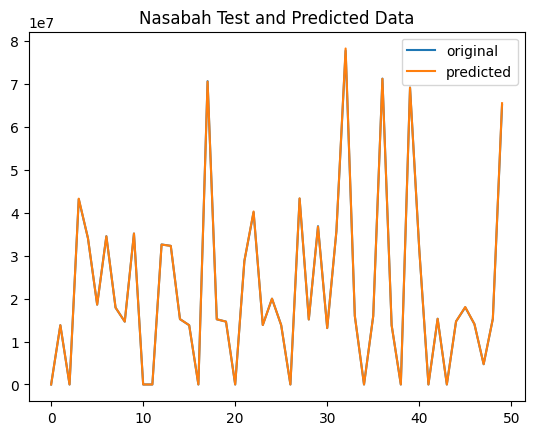

In [13]:
x_ax = range(len(y_test[:50]))
plt.plot(x_ax, y_test[:50], label="original")
plt.plot(x_ax, y_pred[:50], label="predicted")
plt.title("Nasabah Test and Predicted Data")
plt.legend()
plt.show()

In [14]:

# Tentukan model Bagging Regressor dengan estimator dasar (base estimator) yang sesuai
base_estimator = DecisionTreeRegressor()  # Contoh, Anda dapat mengganti ini dengan algoritma regresi yang lain
bagging_regressor = BaggingRegressor(base_estimator, n_estimators=10)  # Anda dapat menyesuaikan n_estimators sesuai kebutuhan

# Tentukan tipe cross-validation dan hitung skor model
cv_scores = cross_val_score(bagging_regressor, X, y, cv=5)  # Ganti cv dengan jumlah fold yang diinginkan

# Tampilkan hasil skor cross-validation
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99124452 0.98536642 0.99084396 0.99795445 0.9992226 ]
Mean CV Score: 0.9929263899987143


In [15]:
# Inisialisasi model Bagging Regressor
bagging_regressor = BaggingRegressor()

# Menentukan grid hyperparameter yang akan dijelajahi
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}

# Inisiasi GridSearchCV
grid_search = GridSearchCV(estimator=bagging_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Melakukan pencarian hyperparameter terbaik
grid_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
best_params = grid_search.best_params_
print("Hyperparameter terbaik:", best_params)

# Menampilkan skor terbaik
best_score = -grid_search.best_score_
print("Skor terbaik:", best_score)

Hyperparameter terbaik: {'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 100}
Skor terbaik: 4121440521527.7764


In [16]:
model2 = BaggingRegressor(base_estimator, n_estimators=10)
model2.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor())

In [17]:
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mse ** (1/2)
r_square = r2_score(y_test, y_pred)

print(f"""
      Mean Squared Errror : {mse:.2f}
      Mean Absolute Error : {mae:.2f}
      Mean Absolute Percentage Error : {mape:.2f}
      Root Mean Squared Error : {mape:.2f}
      R_Squared : {r_square:.2f}
      """)


      Mean Squared Errror : 204367847222.22
      Mean Absolute Error : 71191.67
      Mean Absolute Percentage Error : 0.00
      Root Mean Squared Error : 0.00
      R_Squared : 1.00
      


In [18]:
import pickle

pickle.dump(model2, open("bagging2.pkl", "wb"))

In [19]:
load_model = joblib.load('bagging2.pkl')

input_data = [x for x in X_test.iloc[-1]]
final_features = [np.array(input_data)]
result = load_model.predict(final_features)[0]
result

c:\Users\DHONI HANIF\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


12062499.999999996

In [20]:
y_test.iloc[-1]

12041666.666666666